# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Примечания:

• Для оценки качества моделей применяйте метрику RMSE.

• Значение метрики RMSE должно быть меньше 2500.

• Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.

• Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.

• Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.


## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm
!pip install -q category_encoders
from category_encoders.m_estimate import MEstimateEncoder

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data.head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
display(data.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
display(data.duplicated().sum())

4

Видим, что не все параметры будут нужны для нашей цели. DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen - удаляем.

Есть дубликаты, которые необходимо удалить.

В признаках, влияющих на цену, есть пропуски.

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
del data['DateCrawled'], data['DateCreated'], data['NumberOfPictures'], data['PostalCode'], data['LastSeen'], data['RegistrationMonth']

In [10]:
data['RegistrationYear'].value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

In [11]:
year = data.pivot_table(index='RegistrationYear', values='Brand', aggfunc='count')
year.columns = ['all']
year

,all
RegistrationYear,
1000,37
1001,1
1039,1
1111,3
1200,1
...,...
9000,3
9229,1
9450,1


In [12]:
# Сделаем выборку согласно графику, видим что всплеск начинается в 1980 и заканчивается в 2016
data = data.query('1980 < RegistrationYear <= 2016')

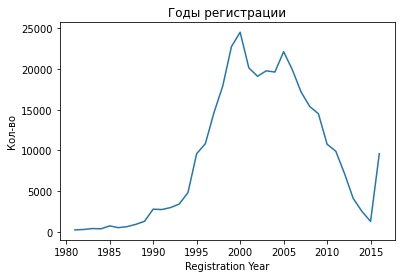

In [13]:
filtered_data = data.loc[(data['RegistrationYear'] > 1980) & (data['RegistrationYear'] <= 2016)]
year = data.pivot_table(index='RegistrationYear', values='Brand', aggfunc='count')
year.columns = ['all']
plt.plot(year.index, year['all'])
plt.xlabel('Registration Year')
plt.ylabel('Кол-во')
plt.title('Годы регистрации')
plt.show()

In [15]:
data.Power.value_counts()

0        35059
75       22716
60       15043
150      14106
101      12710
         ...  
15001        1
1597         1
1436         1
2461         1
6006         1
Name: Power, Length: 694, dtype: int64

In [16]:
data.Power.describe()

count    335795.000000
mean        111.475954
std         185.634965
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [17]:
# исходя из анализа мы знаем что минимальное кол-во лошадей 10, а максимальное 1600, сделаем нужную для нас выборку
data = data.query('10 <= Power <= 1600')

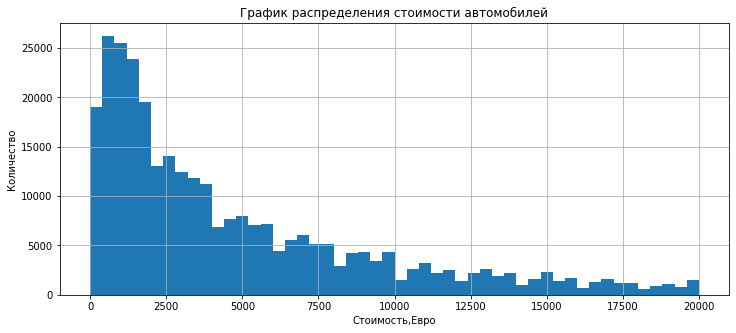

In [18]:
data.Price.hist(bins=50,figsize=(12,5))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

In [19]:
data[data['Price'] < 10]['Price'].count()

6962

In [20]:
# Удалим данные стоимости автомобилей ниже 10€, т.к. такие значения нам не интересны.
data = data.query('Price> 10')

In [21]:
data.loc[data['Price'] < 10]['Price'].count()

0

In [22]:
data['VehicleType'].value_counts()

sedan          82105
small          69685
wagon          59086
bus            26083
convertible    18391
coupe          14093
suv            10803
other           2341
Name: VehicleType, dtype: int64

In [23]:
data['VehicleType'] = data['VehicleType'].fillna('undefined')

In [24]:
data['VehicleType'].value_counts()

sedan          82105
small          69685
wagon          59086
bus            26083
convertible    18391
coupe          14093
suv            10803
undefined      10795
other           2341
Name: VehicleType, dtype: int64

In [25]:
data.query('Model.isna()')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
81,350,small,1997,manual,54,NaN,150000,NaN,fiat,yes
135,1450,sedan,1992,manual,136,NaN,150000,NaN,audi,no
151,6799,small,2009,NaN,60,NaN,20000,petrol,volkswagen,no
161,1495,wagon,2001,NaN,64,NaN,150000,gasoline,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354077,200,small,1998,manual,37,NaN,150000,petrol,volkswagen,yes
354234,5000,sedan,2002,auto,170,NaN,150000,petrol,audi,no
354245,560,small,2001,auto,170,NaN,90000,petrol,fiat,yes
354321,9400,wagon,2007,manual,200,NaN,150000,gasoline,sonstige_autos,yes


In [26]:
# Модель- основной фактор, который на прямую влияет на цены и заменить его на что-либо мы не можем
data.dropna(subset=['Model'], inplace=True)

In [27]:
# тут данные не требуют изменений
data.Kilometer.describe()

count    282880.000000
mean     128508.289734
std       36413.249319
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [28]:
data.query('Gearbox.isna()')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
16,300,undefined,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
92,250,undefined,2000,NaN,60,ka,150000,NaN,ford,NaN
208,2250,small,2001,NaN,41,fortwo,150000,gasoline,smart,no
233,3750,undefined,2005,NaN,75,golf,150000,NaN,volkswagen,NaN
276,2400,convertible,2001,NaN,115,golf,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354005,210,small,1997,NaN,60,polo,150000,NaN,volkswagen,NaN
354133,250,small,1994,NaN,75,golf,150000,petrol,volkswagen,no
354260,399,other,1994,NaN,1103,3er,150000,NaN,bmw,NaN
354285,3500,small,2001,NaN,75,corsa,90000,petrol,opel,no


In [29]:
# так как коробка передач важное значение, а чем-то конкретным пропущенное мы заменить не можем, то просто удвляем данные.
data.dropna(subset=['Gearbox'], inplace=True)

In [30]:
data.FuelType.value_counts()

petrol      176616
gasoline     84810
lpg           4344
cng            459
hybrid         178
other           62
electric        52
Name: FuelType, dtype: int64

In [31]:
data.FuelType.isna().sum()

11788

In [32]:
data['FuelType']=data['FuelType'].fillna('other')

In [33]:
data.Brand.unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

In [34]:
data.Repaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [35]:
data.Repaired.isna().sum()

36733

In [36]:
data['Repaired']=data['Repaired'].fillna('undefined')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278309 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             278309 non-null  int64 
 1   VehicleType       278309 non-null  object
 2   RegistrationYear  278309 non-null  int64 
 3   Gearbox           278309 non-null  object
 4   Power             278309 non-null  int64 
 5   Model             278309 non-null  object
 6   Kilometer         278309 non-null  int64 
 7   FuelType          278309 non-null  object
 8   Brand             278309 non-null  object
 9   Repaired          278309 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.4+ MB


<font color='4682B4'>От первоначальных данных мы потеряли 16% ин-ции </font>

Промежуточный вывод.

Мы рассмотрели каждый столбец - признак, по которым в дальнейшем будет анализ. В них мы либо заменили лио удалили значения, либо добавили отсутствующие 

<font color='4682B4'>принято</font>

## Обучение моделей

In [38]:
features = data.drop('Price', axis=1)
target = data.Price

In [39]:
#через признаки через OHE:
features = pd.get_dummies(features, columns=['Gearbox','FuelType','Repaired','VehicleType'], drop_first=True)

In [40]:
features_train, features_test_1, target_train, target_test_1 = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_test_1, target_test_1, test_size=0.5, random_state=12345)

In [41]:
for i in [features_train,features_valid, features_test, target_valid, target_train, target_test]:
    print(i.shape)

(166985, 22)
(55662, 22)
(55662, 22)
(55662,)
(166985,)
(55662,)


In [42]:
# MEstimateEncode
category_features = ['Brand', 'Model']

encoder = MEstimateEncoder(cols=category_features, m=5.0)
encoder.fit(features_train[category_features], target_train)

features_train[category_features] = encoder.transform(features_train[category_features])
features_test[category_features] = encoder.transform(features_test[category_features])
features_valid[category_features] = encoder.transform(features_valid[category_features])


/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [43]:
features_train.shape

(166985, 22)

In [44]:
features_train.head()

,RegistrationYear,Power,Model,Kilometer,Brand,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,...,Repaired_undefined,Repaired_yes,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_undefined,VehicleType_wagon
130686,2005,200,6213.518071,150000,6818.144486,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
283028,1997,130,1579.430662,150000,4683.587790,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
268620,2002,163,6560.866114,150000,6324.531372,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
251612,2001,75,2382.211653,150000,2618.059631,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
109860,2010,60,3822.421675,80000,4450.471576,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [45]:
# масштибируем признаки
numeric_columns = ['RegistrationYear', 'Power', 'Kilometer','Brand', 'Model']
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])

features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])

/tmp/ipykernel_48/4206938775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_48/4206938775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [46]:
features_train.head()

,RegistrationYear,Power,Model,Kilometer,Brand,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,...,Repaired_undefined,Repaired_yes,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_undefined,VehicleType_wagon
130686,0.321673,1.342396,0.538070,0.589695,1.253925,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
283028,-1.054011,0.142914,-1.358653,0.589695,-0.146521,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
268620,-0.194208,0.708384,0.680239,0.589695,0.930074,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
251612,-0.366169,-0.799537,-1.030077,0.589695,-1.501678,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
109860,1.181476,-1.056569,-0.440601,-1.333845,-0.299464,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [47]:
features_test.shape

(55662, 22)

**Модель LinearRegression**

In [48]:
#напишем функцию
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

In [49]:
%%time
start = time.time()
model_lr=LinearRegression(normalize=True)
model_lr.fit(features_train,target_train)
end = time.time()
t_lr=round(end-start,2)

CPU times: user 291 ms, sys: 126 ms, total: 417 ms
Wall time: 386 ms


In [50]:
%%time
start = time.time()
predict_lr=model_lr.predict(features_test)
end = time.time()
t_lr_p=round(end-start,2)

CPU times: user 15.5 ms, sys: 4.6 ms, total: 20.1 ms
Wall time: 86.3 ms


In [51]:
%%time
valid_predict_lr = model_lr.predict(features_valid)

CPU times: user 9.03 ms, sys: 6.61 ms, total: 15.6 ms
Wall time: 7.5 ms


In [52]:
#%%time

#model_lr = LinearRegression()

#cvs_rmse_lr = (cross_val_score(model_lr, features_train, target_train, cv=5, scoring='neg_mean_squared_error')).mean() ** .5
#cvs_rmse_lr

In [53]:
mae_lr = mean_absolute_error(target_test , predict_lr)
print('MAE модели Линейная Регрессия равна:',mae_lr.round(2))
rmse_lr = rmse(target_test , predict_lr)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

MAE модели Линейная Регрессия равна: 1851.37
RMSE модели Линейная Регрессия равна: 2562.71


**Модель RandomForestRegressor**

In [54]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100)
model_rf.fit(features_train, target_train)
end = time.time()
t_rf=round(end-start,2)

CPU times: user 1min 4s, sys: 783 ms, total: 1min 5s
Wall time: 1min 5s


In [55]:
%%time
start = time.time()
pred_rf=model_rf.predict(features_test)
end = time.time()
t_rf_p=round(end-start,2)

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.53 s


In [56]:
%%time
valid_predict_rf = model_rf.predict(features_valid)

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.53 s


In [57]:
#%%time
#model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100)
#cvs_rmse_rf = (cross_val_score(model_rf, features_train, target_train, cv=5, scoring='neg_mean_squared_error')).mean() ** .5
#cvs_rmse_rf

In [58]:
mae_random_forest = mean_absolute_error(target_test , pred_rf)
print('MAE модели Случайный лес равна:',mae_lr.round(2))
random_forest_rmse = rmse(target_test, pred_rf)
print('RMSE модели Случайный лес равна:', random_forest_rmse)

MAE модели Случайный лес равна: 1851.37
RMSE модели Случайный лес равна: 1502.8


**LightGBM**

In [59]:
%%time
start = time.time()
model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

lgbmr = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
lgbmr.fit(features_train, target_train)

print(lgbmr.best_params_)
print()

mts = lgbmr.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr
end = time.time()
t_lgb=round(end-start,2)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 6, in <module>
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 1288, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 795, in evaluate_candidates
    out = parallel(delayed(_fit_and_score)(clone(base_estimator),
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/si

TypeError: object of type 'NoneType' has no len()

In [ ]:
%%time
start = time.time()
model_gbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_gbmr.fit(features_train, target_train)
end = time.time()
t_lgb_p=round(end-start,2)

In [ ]:
%%time

valid_predict_lgbmr = model_gbmr.predict(features_valid)

In [ ]:
lgbm_predictions = lgbmr.predict(features_test)
mae_lgbmr = mean_absolute_error(target_test , lgbm_predictions)
print('MAE модели LightGBM равна:',mae_lgbmr.round(2))
random_lgbmr_rmse = rmse(target_test, lgbm_predictions)
print('RMSE модели LightGBM равна:', random_lgbmr_rmse)

**CatBoostRegressor**

In [ ]:
%%time

model_cbr = CatBoostRegressor() 
parameter = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameter, scoring='neg_mean_squared_error')
gscv.fit(features_train, target_train)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr = (max(mts) * -1) ** .5
gscv_rsme_cbr
end = time.time()
t_cat=round(end-start,2)

In [ ]:
%%time
start = time.time()
predict_cat = gscv.best_estimator_.predict(features_valid)
end = time.time()
t_cat_p = round(end - start, 2)

In [ ]:
mae_cbr = mean_absolute_error(target_test , predict_cat)
print('MAE модели CatBoostRegressor равна:',mae_lr.round(2))
cbr_rmse = rmse(target_test, predict_cat)
print('RMSE модели CatBoostRegressor равна :', cbr_rmse)

## Анализ моделей

In [ ]:

tablе = pd.DataFrame(index=['RMSE модели', 'MAE модели', 'Скорость обучения, s', 'Скорость предсказания, s'], columns=['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightGBM'])
tablе['LinearRegression'] = rmse_lr, mae_lr, t_lr, t_lr_p
tablе['RandomForestRegressor'] = random_forest_rmse, mae_random_forest, t_rf, t_rf_p
tablе['CatBoostRegressor'] = cbr_rmse,mae_cbr, t_cat, t_cat_p
tablе['LightGBM'] = random_lgbmr_rmse,mae_lgbmr,t_lgb,t_lgb_p
tablе


Исходя из сводных данных, видим что лучшая модель RandomForest

In [ ]:
%%time
model_t_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100)
model_t_rf.fit(features_valid, target_valid)
predictions_test_rf = model_t_rf.predict(features_test)
print(rmse(target_test, predictions_test_rf) ** .5)


Видим, что наша  модель показала лучшие результаты 

Проанализированы время обучения, время предсказания и качество моделей.

Выбрана лучшая модель, и проверено её качество на тестовой выборке.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.


- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей